One problem with learning MCMC samplers using our method is the difficulty of obtaining a good estimate of the transition probabilities. This is mainly because the transition probabilities involve intractable integrals. For example, for the Metropolis-Hastings algorithm, the transition probability in the reject case involves an integral over all possible states. In our current implementation, we approximate this using the current sample but that is far from a good estimate. What if we focus on sampling techniques that do not involve accept/reject operations? In that case, there will be no issues with estimating the transition probabilities, and this will probably lead to a much more efficient algorithm. 

I decided to look at importance sampling first. Importance sampling is not really a sampling technique; it is a method for estimating expectations with respect to a target distribution using samples from a easy-to-sample from proposal distribution. However, since the optimal proposal distribution for importance sampling is the target distribution itself, if we can learn the optimal proposal, we will have learned a good sampler for the target distribution. The optimal proposal distribution is the one that leads to equal importance weights for each sample. Hence, the variance of importance weights is a good measure of the quality of a sampler. More formally, let $p(x)=\frac{p^*(x)}{Z}$ be our target distribution and $q_{\theta}$ be our proposal distribution. We would like to calculate some expectation with respect to $p$: $\mathbb{E}_p[f(x)]$. In importance sampling, we get $N$ samples $x_1, \dots, x_N$ from $q_{\theta}$ and use these to calculate the desired expectation:
$$
\mathbb{E}_p[f(x)] = \int \frac{p^*(x)}{Z} f(x) dx = \frac{\int p^*(x) \frac{q(x)}{q(x)} f(x) dx}{\int p^*(x) \frac{q(x)}{q(x)} dx}
$$
Defining $w(x) = \frac{p^*(x)}{q(x)}$, we can write
$$
\mathbb{E}_p[f(x)] = \frac{\int q(x) w(x) f(x) dx}{\int q(x) w(x) dx} \approx \frac{\sum_{x \sim q} w(x) f(x)}{\sum_{x \sim q} w(x)}
$$
The optimal $q$ is the target distribution $p$ itself, in which case all $w$ are equal. Therefore, for the optimal $q$, the variance of importance weights is 0, $\text{Var}(w) = 0$. Now, if we use the negative variance of importance weights as our reward function, we can measure the goodness of a proposal distribution with the following expectation
$$
\mathbb{E}_{(x_1,\dots,x_N) \sim q_{\theta}} [-\text{Var}((w(x_1),\dots,w(x_N))]
$$
Then we can learn a better proposal by maximizing this expectation with respect to $\theta$. We can get an estimate of the gradient of this expectation using a REINFORCE-style algorithm (see Manuscript for details). However, differently from the case in our Manuscript, now the reward function (i.e., variance of importance weights) depends on $\theta$ too (importance weights involve $q$ which depend on $\theta$). Taking this into account, we get the following expression for the gradient
$$
\nabla_{\theta} \mathbb{E}_{(x_1,\dots,x_N) \sim q_{\theta}} [-\text{Var}((w(x_1),\dots,w(x_N))] \approx \sum_{(x_1,\dots,x_N) \sim q_{\theta}} -\nabla_{\theta} \log \left( \prod_{n=1}^{N} q_{\theta}(x_n) \right) \text{Var}((w(x_1),\dots,w(x_N)) \\ - \sum_{(x_1,\dots,x_N) \sim q_{\theta}} \nabla_{\theta} \text{Var}((w(x_1),\dots,w(x_N)) 
$$
where we get an extra second term involving the gradient of the reward function. In some cases (e.g., when we can differentiate the target distribution), we can reparameterize $q$ and get a more efficient estimate of the gradient. We will see an example of this in the below 1D Gaussian example. 

Note that what we have talked about so far is not really a Markov chain technique because samples are drawn independently from $q$. However, we can modify the above to use a Markov chain as we will see below.


###1D Gaussian example
Let us look at a simple example. We'd like to sample from $p(x) = \mathcal{N}(0, 1)$ using a Gaussian distribution $q_{m,s}(x) = \mathcal{N}(m, s^2)$. Let $x_1, \dots, x_N$ be samples from $q_{m,s}$. Our objective, which measures the goodness of proposal $q$, can be written as
$$
\mathbb{E}_{(x_1,\dots,x_N) \sim q_{m,s}} [-\text{Var}((w(x_1),\dots,w(x_N)))] = -\sum_{(x_1,\dots,x_N)} \left(\prod_{n=1}^{N} q_{m,s}(x_n) \right) \text{Var}((w(x_1),\dots,w(x_N)))
$$
Reparameterize $q_{m,s}$ to get
$$
-\sum_{(x_1,\dots,x_N)} \left(\prod_{n=1}^{N} q_{m,s}(x_n) \right) \text{Var}((w(x_1),\dots,w(x_N))) = -\sum_{(\epsilon_1,\dots,\epsilon_N)} \left(\prod_{n=1}^{N} \mathcal{N}(\epsilon_n;0, 1) \right) \text{Var}((w(m + s\epsilon_1),\dots,w(m + s\epsilon_N)))
$$
where $(\epsilon_1,\dots,\epsilon_N) \sim \mathcal{N}(0,1)$. Then the gradient is
$$
\nabla_{m,s} -\sum_{(\epsilon_1,\dots,\epsilon_N)} \left(\prod_{n=1}^{N} \mathcal{N}(\epsilon_n;0, 1) \right) \text{Var}((w(m + s\epsilon_1),\dots,w(m + s\epsilon_N))) \approx -\sum_{(\epsilon_1,\dots,\epsilon_N) \sim \mathcal{N}(0,1)} \nabla_{m,s} \text{Var}((w(m + s\epsilon_1),\dots,w(m + s\epsilon_N)))
$$
The code below does gradient ascent using this gradient estimate to learn the optimal $m$ and $s$.

In [158]:
import autograd.numpy as np
import autograd as ag

def p(x):
    """
    Unnormalized target distribution
    """
    return np.exp(-0.5*(x)**2)

def q(x, params):
    """
    Proposal probability q(x)
    We don't use this.
    """
    m, logs = params
    s = np.exp(logs)
    return (1./np.sqrt(2.*np.pi)) * (1./s) * np.exp(-0.5*(x-m)**2/(s**2))

def unit_normal(e):
    """
    Unit normal pdf
    """
    return (1./np.sqrt(2.*np.pi)) * np.exp(-0.5*e**2)

def reward(es, params):
    """
    Calculate the reward for a given set of samples.
    es are samples from a unit normal used to calculate samples from q.
    """
    m, logs = params
    s = np.exp(logs)
    px = p(m + es*s)
    qx = unit_normal(es)
    # importance weights
    wx = px / qx
    # normalize weights
    wx /= np.sum(wx)
    return -np.var(wx)

# gradient of the reward function
grad_reward = ag.grad(reward, argnum=1)

In [159]:
m = np.random.randn()
logs = np.random.randn()
params = np.array([m, logs])
print "Initial params:", params
print "True params: [0.0, 0.0]"

samples_per_episode = 20
episode_count = 5000
report_interval = 500
lr = 1.0

for e in range(episode_count):
    es = np.random.randn(samples_per_episode)
    g = grad_reward(es, params)
    params += lr*g
    if (e+1) % report_interval == 0:
        print (e+1) / report_interval, params
print "Learned params:", params

Initial params: [ 0.7975914  -1.63233556]
True params: [0.0, 0.0]
1 [ 0.43329938 -1.32309203]
2 [ 0.01607027 -0.0349198 ]
3 [ 0.00139609 -0.00024249]
4 [  1.29744388e-04  -5.29515308e-07]
5 [  1.24870887e-05  -3.00159895e-07]
6 [  1.18580291e-06  -2.94458797e-08]
7 [  1.13064346e-07   2.02749769e-09]
8 [  1.03415961e-08   3.67767226e-10]
9 [  9.42626877e-10   5.39614571e-11]
10 [  8.33903628e-11  -9.54070361e-13]
Learned params: [  8.33903628e-11  -9.54070361e-13]


###1D Gaussian example with a Markov chain sampler

In the above example, we collected independent samples from $q_{\theta}$ and optimized the variance of importance weights over these samples to learn a good $q_{\theta}$, which we ultimately use to obtain approximate samples from the target distribution $p$. However, such a sampler is limited by the form of $q_{\theta}$. Since we use a simple $q_{\theta}$ (i.e., a Gaussian distribution) in most cases, we won't be able to learn a good approximation to $p$. What if we use a Markov chain instead of obtaining independent samples from $q_{\theta}$? Imagine we learn the transition kernel $q_{\theta}(x_t|x_{t-1})$ for a Markov chain. Hence each sample is in fact a collection of samples $x_1,\dots,x_T$. In other words, our target distribution is $p(x_1, \dots, x_T)$ and we are doing sequential importance sampling with proposal distribution $q_{\theta}(x_t|x_{t-1})$. All $x_t$ have the same distribution $p(x)$ and $p(x_t|x_{t-1}) = p(x_t)$. Again, the importance weight for a sample $\mathbf{x} = x_1,\dots,x_T$ is
$$
w(\mathbf{x}) = \frac{\prod_t p^*(x_t)}{q_1(x_1)\prod_t q_{\theta}(x_t|x_{t-1})}
$$
where $q_1$ is the initial state distribution (which we assume is fixed and do not learn). Now we can apply the approach outlined above to learn a good $q_{\theta}$. Let $\mathbf{x}_1,\dots, \mathbf{x}_N$ be samples from $q_{\theta}(\mathbf{x})$. Note that each $\mathbf{x}_n$ is in fact a collection of samples $x_1,\dots,x_T$ from the Markov chain defined by $q_{\theta}(x_t|x_{t-1})$. We want to maximize the following expectation
$$
\mathbb{E}_{(\mathbf{x}_1,\dots,\mathbf{x}_N) \sim q_{\theta}} [-\text{Var}((w(\mathbf{x}_1),\dots,w(\mathbf{x}_N)))] = -\sum_{(\mathbf{x}_1,\dots,\mathbf{x}_N)} \left(\prod_{n=1}^{N} q_{\theta}(\mathbf{x}_n) \right) \text{Var}((w(\mathbf{x}_1),\dots,w(\mathbf{x}_N)))
$$

Let $q_{\theta=(w_m,b_m,w_s,b_s)}(x_t|x_{t-1}) = \mathcal{N}(w_m x_{t-1} + b_m, \exp(w_s x_{t-1} + b_s)^2)$. Reparameterize $q_{\theta}$ to get
$$
-\sum_{(\mathbf{x}_1,\dots,\mathbf{x}_N)} \left(\prod_{n=1}^{N} q_{\theta}(\mathbf{x}_n) \right) \text{Var}((w(\mathbf{x}_1),\dots,w(\mathbf{x}_N))) = -\sum_{(\mathbf{\epsilon}_1,\dots,\mathbf{\epsilon}_N)} \left(\prod_{n=1}^{N} \mathcal{N}(\mathbf{\epsilon}_n;0, \mathbf{I}) \right) \text{Var}((w(\theta, \mathbf{\epsilon}_1),\dots,w(\theta, \mathbf{\epsilon}_N)))
$$

Here $q_{\theta}(\mathbf{x}_n) = \mathcal{N}(\mathbf{\epsilon}_n;0, \mathbf{I}) = \prod_{t=1}^{T} \mathcal{N}(\epsilon_{nt};0, 1)$ and $w(\mathbf{x}_n) = w(\theta, \mathbf{\epsilon}_n) = \frac{\prod_t p^*(\theta, \epsilon_nt)}{q_1(\epsilon_{n1})\prod_t N(\epsilon_{nt};0, 1)}$. In the following, we assume $q_1(x) = \mathcal{N}(0,1)$. Again, we can form a Monte Carlo estimate of the gradient of this expression.
$$
\nabla_{\theta} \mathbb{E}_{(\mathbf{x}_1,\dots,\mathbf{x}_N) \sim q_{\theta}} [-\text{Var}((w(\mathbf{x}_1),\dots,w(\mathbf{x}_N)))] \approx -\sum_{(\mathbf{\epsilon}_1,\dots,\mathbf{\epsilon}_N) \sim \mathcal{N}(0, \mathbf{I})} \nabla_{\theta} \text{Var}((w(\theta, \mathbf{\epsilon}_1),\dots,w(\theta, \mathbf{\epsilon}_N)))
$$
The code below does gradient ascent using this gradient estimate to learn the optimal $q$.

In [184]:
import autograd.numpy as np
import autograd as ag

def p(x):
    """
    Unnormalized target distribution
    """
    return np.exp(-0.5*x**2)

def q(xp, x, params):
    """
    Proposal probability q(xp|x)
    We don't use this.
    """
    w_m, b_s, w_logs, b_logs = params
    m = w_m * x + b_m
    logs = w_logs * x + b_logs
    s = np.exp(logs)
    return (1./np.sqrt(2.*np.pi)) * (1./s) * np.exp(-0.5*(x-m)**2/(s**2))

def get_proposal_distribution(x, params):
    w_m, b_m, w_logs, b_logs = params
    m = w_m * x + b_m
    logs = w_logs * x + b_logs
    s = np.exp(logs)
    return m, s    
    
def unit_normal(e):
    """
    Unit normal pdf
    """
    return (1./np.sqrt(2.*np.pi)) * np.exp(-0.5*e**2)

def reward(es, params):
    """
    Calculate the reward for a given set of samples.
    es are N samples from a T dimensional unit normal used to calculate samples from q.
    """
    px = np.zeros(es.shape[0])
    x = es[:, 0]
    px = px + p(x)
    for t in range(1, es.shape[1]):
        m, s = get_proposal_distribution(x, params)
        x = m + es[:, t]*s
        px = px + p(x)
    
    qx = np.sum(unit_normal(es), axis=1)
    # importance weights
    wx = px / qx
    # normalize weights
    wx /= np.sum(wx)
    return -np.var(wx)
    
# gradient of the reward function
grad_reward = ag.grad(reward, argnum=1)

In [161]:
w_m, b_m = np.random.randn(2)
# w_m, b_m = [0.1, 0.2]
w_logs, b_logs = np.random.randn(2) * 0.1
# w_logs, b_logs = [0.15, -0.2]
init_params = np.array([w_m, b_m, w_logs, b_logs])
print "Initial params:", init_params

chain_length = 10
samples_per_episode = 20
episodes_per_epoch = 50
epoch_count = 10

def estimate_grad(params, i, reps=10):
    notnan_count = 0
    tot_g = 0.0
    for _ in range(0, reps):
        es = np.random.randn(samples_per_episode, chain_length)
        g = grad_reward(es, params)
    
        if not np.any(np.isnan(g)):
            tot_g += g
            notnan_count += 1
    return -g / notnan_count

def report_progress(params, i, g):
    if (i+1) % episodes_per_epoch == 0:
        print "Iteration ", i+1, ", params: ", params

from autograd.optimizers import adam

new_params = adam(estimate_grad, init_params, callback=report_progress, 
                  num_iters=epoch_count*episodes_per_epoch, step_size=0.01)
print "Learned params: ", new_params

Initial params: [ 0.47322725 -0.19712538 -0.15801755 -0.0404277 ]
Iteration  50 , params:  [ 0.16891344  0.02214555  0.01604627 -0.14457628]
Iteration  100 , params:  [ 0.03594182  0.00175411 -0.00525639 -0.0019805 ]
Iteration  150 , params:  [  4.76444917e-04   1.07305347e-03  -1.95869994e-04   8.68722901e-05]
Iteration  200 , params:  [ -1.25483150e-04   1.08470168e-04  -9.88970331e-05   8.70638576e-05]
Iteration  250 , params:  [  1.65369863e-05   8.83484519e-06  -1.03442468e-05  -4.27345602e-07]
Iteration  300 , params:  [ -1.47296818e-06   7.30363011e-07  -4.11824583e-07  -7.70735225e-07]
Iteration  350 , params:  [  1.01098106e-07  -1.91269422e-08   3.06195797e-08   7.53500840e-09]
Iteration  400 , params:  [ -7.72668618e-09  -4.06799289e-09   3.85957588e-09   1.07956371e-09]
Iteration  450 , params:  [  5.35235409e-10   2.70979333e-10  -3.22116741e-10   2.18078324e-10]
Iteration  500 , params:  [ -2.36859315e-11   3.79240848e-12  -1.64019694e-12   1.31753273e-11]
Learned params:

As we see above, our method does converge to a solution where all parameters are 0. This is the optimal proposal $q_{\theta}(x_t|x_{t-1}) = \mathcal{N}(0, 1)$, which is the target distribution itself.

###1D Mixture of Gaussians example
The above example is not very useful because the target distribution is simple and can be exactly learned by a single step Markov chain. Therefore, there is not much point in running a Markov chain to get samples. Now, I'd like to look at a target distribution that cannot be learned exactly by a single step Markov chain. 

In [185]:
def p(x):
    """
    Unnormalized target distribution, a mixture of 2 Gaussians
    """
    return np.exp(-0.5*((x-3.0)**2 + (x+3.0)**2))

def get_proposal_distribution(x, params):
    """
    MLP with a single hidden layer
    """
    w_h, b_h, w_o, b_o = params
    h = np.maximum(np.dot(x[:, np.newaxis], w_h) + b_h, 0.0)
    o = np.dot(h, w_o) + b_o
    m = o[:, 0]
    s = np.exp(o[:, 1])
    return m, s

In [186]:
hidden_unit_count = 5
w_h, b_h = np.random.randn(1, hidden_unit_count)*0.01, np.random.randn(hidden_unit_count)*0.01
w_o, b_o = np.random.randn(hidden_unit_count, 2)*0.01, np.random.randn(2)*0.01
init_params = [w_h, b_h, w_o, b_o]
print "Initial params:", init_params

chain_length = 2
samples_per_episode = 20
episodes_per_epoch = 100
epoch_count = 20

def estimate_reward(params, i, reps=10):
    tot_r = 0
    for _ in range(0, reps):
        es = np.random.randn(samples_per_episode, chain_length)
        r = reward(es, params)
        if not np.isnan(r):
            tot_r += r
    return -tot_r / reps

estimate_grad = ag.grad(estimate_reward, argnum=0)

def report_progress(params, i, g):
    if (i+1) % episodes_per_epoch == 0:
        print "Iteration", i+1, ", reward:", estimate_reward(params, 0, reps=100)

from autograd.optimizers import adam

new_params = adam(estimate_grad, init_params, callback=report_progress, 
                  num_iters=epoch_count*episodes_per_epoch, step_size=0.0005)
print "Learned params:", new_params

Initial params: [array([[-0.00164492, -0.00703599, -0.00222673,  0.00650332,  0.01235202]]), array([ 0.00266052,  0.00910101, -0.01043781,  0.01402108,  0.02410367]), array([[ 0.01080268, -0.0076234 ],
       [ 0.0014125 ,  0.00636405],
       [ 0.02105997,  0.00282899],
       [ 0.00583331,  0.00413195],
       [-0.00981871,  0.00461101]]), array([-0.01002317,  0.01563595])]
Iteration  100 , reward:  9.37926103229e-05
Iteration  200 , reward:  6.70920194135e-05
Iteration  300 , reward:  3.34437673073e-05
Iteration  400 , reward:  2.44834140503e-05
Iteration  500 , reward:  2.49889835873e-05
Iteration  600 , reward:  2.49626558336e-05
Iteration  700 , reward:  2.25919763367e-05
Iteration  800 , reward:  2.10479868791e-05
Iteration  900 , reward:  2.24062826549e-05
Iteration  1000 , reward:  1.8265696199e-05
Iteration  1100 , reward:  2.32710591097e-05
Iteration  1200 , reward:  2.18744431908e-05
Iteration  1300 , reward:  2.10094341649e-05
Iteration  1400 , reward:  2.35338710678e-05
I

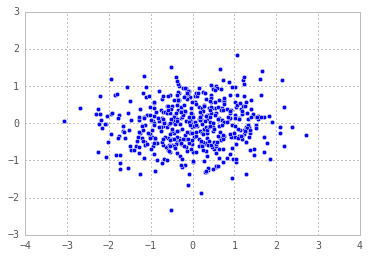

In [191]:
N = 500
x1 = np.random.randn(N)
m, s = get_proposal_distribution(x1, new_params)
x2 = m + s*np.random.randn(N)

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x1, x2)
# plt.hist(x2)

It doesn't seem to learn anything useful. I was hoping that the marginal of $x_2$ would be bimodal (like the target distribution)

Maybe, I should consider only the last state from a chain as a sample. That would require me to get the marginal probability of last state (which is not easy).